# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
    - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    - Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [260]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline

This is run only first time to collect the data. Data is later saved to binary file and loaded from file on PC

In [261]:
#file that was discovered using Interceptor
url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'

#get the data
r = requests.get(url)

#get first 200 universities
data = r.json()['data'][:200]
universities = []

#for every university extract required fileds
#and use BeautifulSoup and university url to get additional info(number of faculty members and number of students)
for u in data:
    university = {
        'name': u['title'],
        'rank': u['rank_display'],
        'country': u['country'],
        'region': u['region']
    }
    r = requests.get('https://www.topuniversities.com/'+u['url'])
    soup = BeautifulSoup(r.text, 'html.parser')
    
    faculty_total_div = soup.find('div', class_='total faculty')
    if faculty_total_div != None:
        university['faculty_total'] = faculty_total_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
    
    faculty_int_div = soup.find('div', class_='inter faculty')
    if faculty_int_div != None:
        university['faculty_international'] = faculty_int_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
        
    student_total_div = soup.find('div', class_='total student')
    if student_total_div != None:
        university['students_total'] = student_total_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
        
    student_int_div = soup.find('div', class_='total inter')
    if student_int_div != None:
        university['students_international'] = student_int_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
    
    universities.append(university)


In [262]:
#create dataframe and convert following column values to float 
#we use float because some values have NaN value, which is not supported with int
df = pd.DataFrame(universities)
df['faculty_total'] = df ['faculty_total'].astype(float)
df['faculty_international'] = df ['faculty_international'].astype(float)
df['students_total'] = df ['students_total'].astype(float)
df['students_international'] = df ['students_international'].astype(float)
#save dataframe as binary file
df.to_pickle("topuniversities")

In [263]:
#load dataframe from binary file
df = pd.DataFrame()
df = pd.read_pickle('topuniversities')
df.head()

,country,faculty_international,faculty_total,name,rank,region,students_international,students_total
0,United States,1679.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,11067.0
1,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0
2,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0
3,United States,350.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,2255.0
4,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0


Now let's see which university is the best based on ratio between faculty members and students.

In [264]:
faculty_students_ratio = df['faculty_total']/df['students_total']
df[['name', 'faculty_total', 'students_total']].\
assign(faculty_students_ratio = faculty_students_ratio.values).sort_values('faculty_students_ratio', ascending=False).head()

,name,faculty_total,students_total,faculty_students_ratio
3,California Institute of Technology (Caltech),953.0,2255.0,0.422616
15,Yale University,4940.0,12402.0,0.398323
5,University of Oxford,6750.0,19720.0,0.342292
4,University of Cambridge,5490.0,18770.0,0.292488
16,Johns Hopkins University,4462.0,16146.0,0.276353


We can see that the best university is California Institute of Technology (Caltech).
Now let's see which university is the best in term of ratio of international students.

In [265]:
int_students_ratio = df['students_international']/df['students_total']
df[['name', 'students_international', 'students_total']].\
assign(int_students_ratio = int_students_ratio.values).sort_values('int_students_ratio', ascending=False).head()

,name,students_international,students_total,int_students_ratio
34,London School of Economics and Political Scien...,6748.0,9760.0,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),5896.0,10343.0,0.570047
7,Imperial College London,8746.0,16090.0,0.543567
198,Maastricht University,8234.0,16385.0,0.502533
47,Carnegie Mellon University,6385.0,13356.0,0.478062


We can see that the best university in terms of ratio of international students is London School of Economics and Political Science. And of course in second place is EPFL :)

Now let's see which country has best faculty members-students ratio.

In [266]:
by_country = df.groupby('country').sum().copy()
by_country_ratio1 = by_country.assign(faculty_students_ratio = by_country['faculty_total']/by_country['students_total']).\
sort_values('faculty_students_ratio', ascending = False)
by_country_ratio1.head()

,faculty_international,faculty_total,students_international,students_total,faculty_students_ratio
country,,,,,
Russia,373.0,6709.0,5098.0,30233.0,0.221910
Denmark,3904.0,11916.0,9543.0,67223.0,0.177261
Saudi Arabia,665.0,1062.0,989.0,6040.0,0.175828
Singapore,6079.0,9444.0,16168.0,58466.0,0.161530
Malaysia,655.0,2755.0,3476.0,17902.0,0.153893


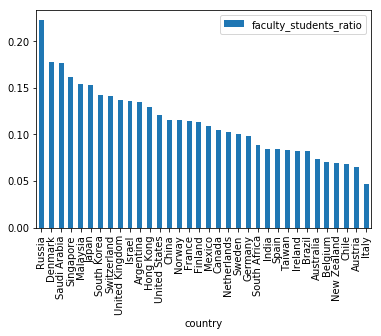

In [267]:
by_country_ratio1.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

We can see that in firts place is Russia. And now lets see which country has best international students ratio.

In [268]:
by_country_ratio2 = by_country.assign(int_students_ratio = by_country['students_international']/by_country['students_total']).\
sort_values('int_students_ratio', ascending = False)
by_country_ratio2.head()

,faculty_international,faculty_total,students_international,students_total,int_students_ratio
country,,,,,
Australia,11382.0,22034.0,106359.0,301994.0,0.352189
United Kingdom,30216.0,79934.0,199426.0,583621.0,0.341705
Hong Kong,6296.0,10166.0,24499.0,78838.0,0.310751
Austria,1572.0,4117.0,19667.0,63446.0,0.309980
Switzerland,9208.0,15323.0,32995.0,109112.0,0.302396


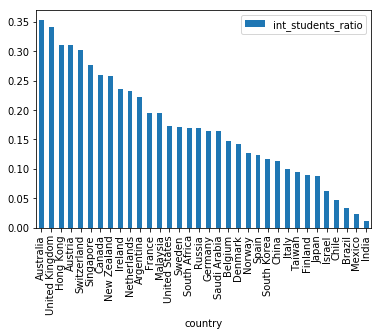

In [269]:
by_country_ratio2.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

We can see that in firts place is Australia, with 106359 international students and ratio of 0.352189. Switzerland is in fifth place. Now let's calculate the same thing, but grouped by region.

In [270]:
by_region = df.groupby('region').sum().copy()
by_region_ratio1 = by_region.assign(faculty_students_ratio = by_region['faculty_total']/by_region['students_total']).\
sort_values('faculty_students_ratio', ascending = False)
by_region_ratio1

,faculty_international,faculty_total,students_international,students_total,faculty_students_ratio
region,,,,,
Asia,25462.0,106734.0,110100.0,807003.0,0.132260
North America,43836.0,182123.0,292116.0,1546353.0,0.117776
Europe,67598.0,218358.0,449364.0,1957251.0,0.111564
Latin America,5648.0,45382.0,36871.0,435750.0,0.104147
Africa,379.0,1733.0,3325.0,19593.0,0.088450
Oceania,12786.0,25347.0,118798.0,350167.0,0.072385


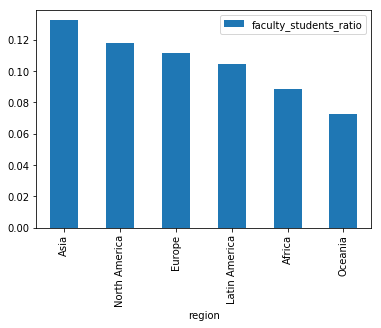

In [271]:
by_region_ratio1.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

When we group by region, we can see that in first place is Asia, and last Oceania. Now let's see what is the international student ratio.

In [272]:
by_region_ratio2 = by_region.assign(int_students_ratio = by_region['students_international']/by_region['students_total']).\
sort_values('int_students_ratio', ascending = False)
by_region_ratio2

,faculty_international,faculty_total,students_international,students_total,int_students_ratio
region,,,,,
Oceania,12786.0,25347.0,118798.0,350167.0,0.339261
Europe,67598.0,218358.0,449364.0,1957251.0,0.229589
North America,43836.0,182123.0,292116.0,1546353.0,0.188906
Africa,379.0,1733.0,3325.0,19593.0,0.169703
Asia,25462.0,106734.0,110100.0,807003.0,0.136431
Latin America,5648.0,45382.0,36871.0,435750.0,0.084615


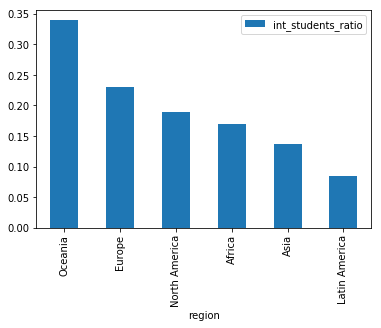

In [273]:
by_region_ratio2.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

While the faculty members-student ratio in Oceania is lowest, it appears like they have the best ratio of international studnets.

## Times Higher Education

In [274]:
#requesting page with first 200 universities
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
#creating parser
data=r.json()['data'][:200]

#creating country to region look-up table from previous result
unique_countries=df['country'].unique()
country_to_region={}
for country in unique_countries:
    region=df[df['country']==country]
    country_to_region[country]=region['region'].iloc[0]

#exception countries that are not mentioned in previous dataframe
country_to_region['Luxembourg']='Europe'
country_to_region

{'Argentina': 'Latin America',
 'Australia': 'Oceania',
 'Austria': 'Europe',
 'Belgium': 'Europe',
 'Brazil': 'Latin America',
 'Canada': 'North America',
 'Chile': 'Latin America',
 'China': 'Asia',
 'Denmark': 'Europe',
 'Finland': 'Europe',
 'France': 'Europe',
 'Germany': 'Europe',
 'Hong Kong': 'Asia',
 'India': 'Asia',
 'Ireland': 'Europe',
 'Israel': 'Asia',
 'Italy': 'Europe',
 'Japan': 'Asia',
 'Luxembourg': 'Europe',
 'Malaysia': 'Asia',
 'Mexico': 'Latin America',
 'Netherlands': 'Europe',
 'New Zealand': 'Oceania',
 'Norway': 'Europe',
 'Russia': 'Europe',
 'Saudi Arabia': 'Asia',
 'Singapore': 'Asia',
 'South Africa': 'Africa',
 'South Korea': 'Asia',
 'Spain': 'Europe',
 'Sweden': 'Europe',
 'Switzerland': 'Europe',
 'Taiwan': 'Asia',
 'United Kingdom': 'Europe',
 'United States': 'North America'}

In [275]:
#declaring the dataframe
times=pd.DataFrame({'Name' : [], 
                    'Rank':[], 
                    'Country':[], 
                    'Region':[], 
                    'FM Total':[],
                    'FM International':[],
                    'Students Total':[],
                    'Students International':[]}) #TODO region and international faculty member is left
# processing the data json
idx=1
for row in data:
    rank=int(row['rank'].replace("=",""))
    name=row['name']
    country=row['location']
    #Exception of country name
    if(country=="Russian Federation"): country="Russia"
    students=int(row['stats_number_students'].replace(",",""))
    ratio=float(row['stats_student_staff_ratio'])
    percent_i=float(row['stats_pc_intl_students'].replace("%",""))   
    #getting region information from country
    region=country_to_region[country]
    times.loc[idx]=[country,None,int(students/ratio),name,rank,region,students*percent_i/100,students]
    idx+=1   
times.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total
1,United Kingdom,None,1822.0,University of Oxford,1.0,Europe,7755.42,20409.0
2,United Kingdom,None,1687.0,University of Cambridge,2.0,Europe,6436.15,18389.0
3,United States,None,339.0,California Institute of Technology,3.0,North America,596.43,2209.0
4,United States,None,2112.0,Stanford University,3.0,North America,3485.90,15845.0
5,United States,None,1284.0,Massachusetts Institute of Technology,5.0,North America,3800.18,11177.0


In [276]:
#general sorting function
def sorter(data,column1,ratio=None,column2=None,filterby=None,filter_val=None,ascending=False):
    result=data.copy(True)
    if filterby!=None:
        result=data[data[filterby]==filter_val].copy(True)
    if ratio!=None:
        result[ratio]=result[column1].divide(result[column2])
        result=result.sort_values(ratio,ascending=ascending)
    else:
        result=result.sort_values(column1,ascending=ascending)
    return result

2.a best universities by ratio between faculty members and students

In [277]:
times_fm_student=sorter(times,'FM Total','fm/student','Students Total')
times_fm_student.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total,fm/student
106,United States,None,3639.0,Vanderbilt University,105.0,North America,1561.43,12011.0,0.302972
110,Denmark,None,7413.0,University of Copenhagen,109.0,Europe,4255.30,30395.0,0.243889
13,United States,None,3604.0,Johns Hopkins University,13.0,North America,3719.52,15498.0,0.232546
12,United States,None,2826.0,Yale University,12.0,North America,2552.55,12155.0,0.232497
154,United States,None,2240.0,University of Rochester,153.0,North America,2794.44,9636.0,0.232462


2.b best universities by ratio of international students

In [278]:
times_intl_student=sorter(times,'Students International','intl/student','Students Total')
times_intl_student.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total,intl/student
25,United Kingdom,None,825.0,London School of Economics and Political Science,25.0,Europe,7146.15,10065.0,0.71
179,Luxembourg,None,340.0,University of Luxembourg,179.0,Europe,2832.33,4969.0,0.57
8,United Kingdom,None,1390.0,Imperial College London,8.0,Europe,8721.35,15857.0,0.55
38,Switzerland,None,886.0,École Polytechnique Fédérale de Lausanne,38.0,Europe,5460.40,9928.0,0.55
103,Netherlands,None,929.0,Maastricht University,103.0,Europe,8363.50,16727.0,0.50


2.c.a Ranking countries by faculty and student ratio

In [279]:
by_country = times.groupby('Country').sum().copy()
times_by_country_ratio1 = by_country.assign(faculty_students_ratio = by_country['FM Total']/by_country['Students Total']).\
sort_values('faculty_students_ratio', ascending = False)
times_by_country_ratio1.head()

,FM Total,Rank,Students International,Students Total,faculty_students_ratio
Country,,,,,
Denmark,10596.0,371.0,9326.86,64110.0,0.165278
Russia,4004.0,194.0,6431.92,29236.0,0.136954
Japan,6464.0,120.0,4398.48,48481.0,0.133331
Italy,157.0,339.0,132.65,1205.0,0.130290
Switzerland,10048.0,666.0,32745.97,107852.0,0.093165


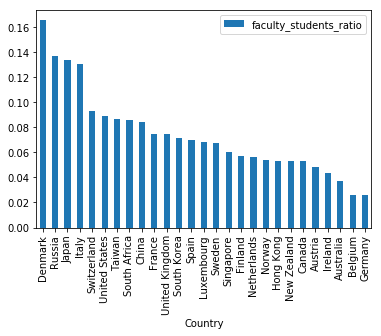

In [280]:
times_by_country_ratio1.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

2.c.b Ranking countries by international student ratio

In [281]:
by_country = times.groupby('Country').sum().copy()
times_by_country_ratio2 = by_country.assign(intl_students_ratio = by_country['Students International']/by_country['Students Total']).\
sort_values('intl_students_ratio', ascending = False)
times_by_country_ratio2.head()

,FM Total,Rank,Students International,Students Total,intl_students_ratio
Country,,,,,
Luxembourg,340.0,179.0,2832.33,4969.0,0.570000
United Kingdom,44425.0,3428.0,213059.74,596449.0,0.357214
Hong Kong,4140.0,443.0,25158.79,77663.0,0.323948
Australia,9937.0,616.0,83811.65,268630.0,0.311997
Singapore,3364.0,74.0,17085.29,56101.0,0.304545


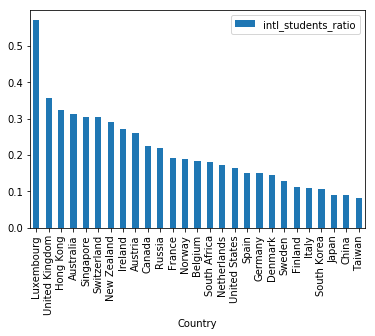

In [282]:
times_by_country_ratio2.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

2.d.a Ranking regions by faculty and student ratio

In [283]:
by_region = times.groupby('Region').sum().copy()
times_by_region_ratio1 = by_region.assign(faculty_students_ratio = by_region['FM Total']/by_region['Students Total']).\
sort_values('faculty_students_ratio', ascending = False)
times_by_region_ratio1.head()

,FM Total,Rank,Students International,Students Total,faculty_students_ratio
Region,,,,,
Africa,1775.0,171.0,3739.50,20775.0,0.085439
North America,165553.0,5197.0,336270.47,1954934.0,0.084685
Asia,42628.0,2091.0,78837.67,530949.0,0.080286
Europe,126816.0,11771.0,481578.91,2143623.0,0.059160
Oceania,11551.0,808.0,92612.57,298978.0,0.038635


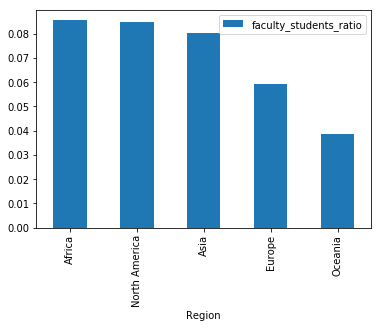

In [284]:
times_by_region_ratio1.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

2.d.b Ranking regions by international student ratio

In [285]:
by_region = times.groupby('Region').sum().copy()
times_by_region_ratio2 = by_region.assign(intl_students_ratio = by_region['Students International']/by_region['Students Total']).\
sort_values('intl_students_ratio', ascending = False)
times_by_region_ratio2.head()

,FM Total,Rank,Students International,Students Total,intl_students_ratio
Region,,,,,
Oceania,11551.0,808.0,92612.57,298978.0,0.309764
Europe,126816.0,11771.0,481578.91,2143623.0,0.224657
Africa,1775.0,171.0,3739.50,20775.0,0.180000
North America,165553.0,5197.0,336270.47,1954934.0,0.172011
Asia,42628.0,2091.0,78837.67,530949.0,0.148484


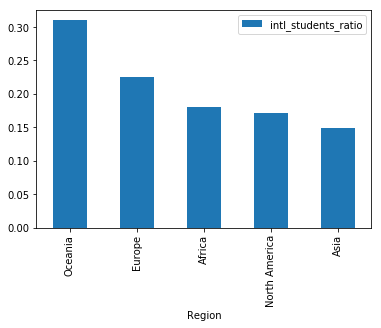

In [286]:
times_by_region_ratio2.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

## 2. Merging the 2 dataframe

In [287]:
top_merge=df.assign(top_fm_student=df['faculty_total']/df['students_total'])
top_merge=top_merge.assign(top_intl_student=df['students_international']/df['students_total'])
top_merge=top_merge.drop(['country','faculty_international','faculty_total','region','students_international','students_total'],axis=1)

top_merge.head()

,name,rank,top_fm_student,top_intl_student
0,Massachusetts Institute of Technology (MIT),1,0.269450,0.335863
1,Stanford University,2,0.269870,0.227422
2,Harvard University,3,0.193945,0.234785
3,California Institute of Technology (Caltech),4,0.422616,0.286918
4,University of Cambridge,5,0.292488,0.356899


In [288]:
times_merge=times.assign(times_fm_student=times['FM Total']/times['Students Total'])
times_merge=times_merge.assign(times_intl_student=times['Students International']/times['Students Total'])
times_merge=times_merge.drop(['Country','FM International','FM Total','Region','Students International','Students Total'],axis=1)
times_merge["name"]=None
times_merge.head()

,Name,Rank,times_fm_student,times_intl_student,name
1,University of Oxford,1.0,0.089274,0.38,None
2,University of Cambridge,2.0,0.091740,0.35,None
3,California Institute of Technology,3.0,0.153463,0.27,None
4,Stanford University,3.0,0.133291,0.22,None
5,Massachusetts Institute of Technology,5.0,0.114879,0.34,None


In [289]:
top_names=top_merge['name'].unique()
#first layer by name
def name_checker1(a,blist):
    for b in blist:
        if(a in b): return b
    return None
used=[]
for idx in range(1,201):
    name=name_checker1(times_merge.at[idx,'Name'],top_names)
    if name!=None:
        used.append(name)
    times_merge.at[idx,'name']=name
top_names=list(set(top_names) - set(used))


#second layer by word
def name_checker2(a,blist):
    max_tuple=(-1,0)
    for b in blist:
        awords=a.split(' ')
        cnt=0
        accepted=0
        for word in awords:
            if 'Univer' in word: continue
            if len(word) < 3 : continue
            if word in b:
                cnt+=1
            accepted+=1
        if max_tuple[0]<(cnt/accepted):
            max_tuple=(cnt/accepted,b)
    if(max_tuple[0]>0.5): 
        return max_tuple[1]
    return None
used=[]
for idx in range(1,201):
    if times_merge.at[idx,'name']==None:
        name=name_checker2(times_merge.at[idx,'Name'],top_names)
        if name!=None:
            used.append(name)
        times_merge.at[idx,'name']=name
top_names=list(set(top_names) - set(used))


#third layer by character
def lcs(atext,btext):
    a_arr=list(atext)
    b_arr=list(btext)
    cnt=0
    v_lcs=0
    matrix=[]
    maxloc=[0,0]
    matrix.append([0]*(len(b_arr)+1))
    for i in range(1,len(a_arr)+1):
        matrix.append([])
        matrix[i].append(0)
        for j in range(1,len(b_arr)+1):
            matrix[i].append(0)
            if a_arr[i-1]==b_arr[j-1]:
                matrix[i][j]=matrix[i-1][j-1]+1
                if(v_lcs<matrix[i][j]):
                    v_lcs=matrix[i][j]
                    maxloc=[i,j]
            else:
                if(matrix[i-1][j]>matrix[i][j-1]):
                    matrix[i][j]=matrix[i-1][j]
                else:
                    matrix[i][j]=matrix[i][j-1]
    return matrix[len(a_arr)][len(b_arr)]/len(a_arr), matrix[len(a_arr)][len(b_arr)]/len(b_arr)
def name_checker3(a,blist):
    max_tuple=(-1,0)
    t_a=a.replace('Universit','')
    t_a=t_a.replace('Institut','')
    for b in blist:
        t_b=b.replace('Universit','')
        t_b=t_b.replace('Institut','')
        a_p,b_p=lcs(t_a,t_b)
        if max_tuple[0]<(a_p+b_p): max_tuple=(a_p+b_p,b)
    if(max_tuple[0]>=1.261): return max_tuple[1]
    return None
used=[]
for idx in range(1,201):
    if times_merge.at[idx,'name']==None:
        name=name_checker3(times_merge.at[idx,'Name'],top_names)
        if name!=None:
            used.append(name)
        times_merge.at[idx,'name']=name
top_names=list(set(top_names) - set(used))


times_merge

,Name,Rank,times_fm_student,times_intl_student,name
1,University of Oxford,1.0,0.089274,0.38,University of Oxford
2,University of Cambridge,2.0,0.091740,0.35,University of Cambridge
3,California Institute of Technology,3.0,0.153463,0.27,California Institute of Technology (Caltech)
4,Stanford University,3.0,0.133291,0.22,Stanford University
5,Massachusetts Institute of Technology,5.0,0.114879,0.34,Massachusetts Institute of Technology (MIT)
6,Harvard University,6.0,0.112319,0.26,Harvard University
7,Princeton University,7.0,0.120427,0.24,Princeton University
8,Imperial College London,8.0,0.087658,0.55,Imperial College London
9,University of Chicago,9.0,0.161257,0.25,University of Chicago
10,ETH Zurich – Swiss Federal Institute of Techno...,10.0,0.068476,0.38,ETH Zurich - Swiss Federal Institute of Techno...


In [297]:
universities=pd.merge(top_merge,times_merge,on='name')
universities

,name,rank,top_fm_student,top_intl_student,Name,Rank,times_fm_student,times_intl_student
0,Massachusetts Institute of Technology (MIT),1,0.269450,0.335863,Massachusetts Institute of Technology,5.0,0.114879,0.34
1,Stanford University,2,0.269870,0.227422,Stanford University,3.0,0.133291,0.22
2,Harvard University,3,0.193945,0.234785,Harvard University,6.0,0.112319,0.26
3,California Institute of Technology (Caltech),4,0.422616,0.286918,California Institute of Technology,3.0,0.153463,0.27
4,University of Cambridge,5,0.292488,0.356899,University of Cambridge,2.0,0.091740,0.35
5,University of Oxford,6,0.342292,0.372870,University of Oxford,1.0,0.089274,0.38
6,UCL (University College London),7,0.204151,0.477928,University College London,16.0,0.095235,0.49
7,Imperial College London,8,0.244251,0.543567,Imperial College London,8.0,0.087658,0.55
8,University of Chicago,9,0.180645,0.249244,University of Chicago,9.0,0.161257,0.25
9,ETH Zurich - Swiss Federal Institute of Techno...,10,0.125006,0.381681,ETH Zurich – Swiss Federal Institute of Techno...,10.0,0.068476,0.38
